# Business Understanding - Defining the problem


###### The purpose of this excercise is to take the various parameters in the dataset and determine what materially impacts Energy Use Intensity. After creating a model, we need to determine what  factors minimize energy use intensity and what design parameters should building designers, building operators and policy makes keep in mind to design the most energy efficient buildings

In [2]:
#Importing libraries that are needed to carry out the analysis
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import datetime 
import warnings
warnings.filterwarnings('ignore') #Ignoring warnings

###### Importing the data that needs to be analyzed and cleaning it to get it into a form where an analysis can be carried out

In [3]:
#Reading in the buildings data into a dataframe and understanding the data.
data_df = pd.read_csv('train.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [4]:
# Dropping average temperature since that data is captured in minimum and maximum temperature. Also, dropping building class and retaining facility type.
# Given the large number of null values I decided to drop more columns of direction_max_wind_speed, direction_peak_wind_speed, max_wind_speed and days_With_fog 
data_df_clean = data_df.drop(['january_avg_temp', 'february_avg_temp','march_avg_temp','april_avg_temp','may_avg_temp',
                             'june_avg_temp','july_avg_temp', 'august_avg_temp','september_avg_temp',
                             'october_avg_temp', 'november_avg_temp','december_avg_temp','building_class','id'
                             ,'direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog'],axis=1)
data_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year_Factor           75757 non-null  int64  
 1   State_Factor          75757 non-null  object 
 2   facility_type         75757 non-null  object 
 3   floor_area            75757 non-null  float64
 4   year_built            73920 non-null  float64
 5   energy_star_rating    49048 non-null  float64
 6   ELEVATION             75757 non-null  float64
 7   january_min_temp      75757 non-null  int64  
 8   january_max_temp      75757 non-null  int64  
 9   february_min_temp     75757 non-null  int64  
 10  february_max_temp     75757 non-null  int64  
 11  march_min_temp        75757 non-null  int64  
 12  march_max_temp        75757 non-null  int64  
 13  april_min_temp        75757 non-null  int64  
 14  april_max_temp        75757 non-null  int64  
 15  may_min_temp       

In [36]:
#Determining if we can drop correlated columns. Even though there are some highly correlated columns there is no clear pattern and hence all columns have been retained.
data_df_clean.corr().iloc[[6,8,10,12,14,16,18,20,22,24,26,28],[29]]

,cooling_degree_days
january_max_temp,-0.120715
february_max_temp,-0.351670
march_max_temp,-0.029049
april_max_temp,-0.114111
may_max_temp,0.512930
june_max_temp,0.029640
july_max_temp,0.599809
august_max_temp,0.625287
september_max_temp,0.634407
october_max_temp,0.327495


###### From the above correlation matrix we can see that the maximum temperature and cooling degree days are highly correlated and hence I am retaining on heating degree days to represent overall temperatures with an overall correlation of 0.33

In [37]:
#Determining if we can drop correlated columns. Even though there are some highly correlated columns there is no clear pattern and hence all columns have been retained.
data_df_clean.corr().iloc[[5,7,9,11,13,15,17,19,21,23,25,27],[30]]

,heating_degree_days
january_min_temp,-0.890905
february_min_temp,-0.701092
march_min_temp,-0.797233
april_min_temp,-0.703473
may_min_temp,-0.383899
june_min_temp,-0.182394
july_min_temp,0.164759
august_min_temp,-0.008710
september_min_temp,-0.223759
october_min_temp,-0.653565


###### From the above correlation matrix we can see that the minimum temperature and heating degree days are highly correlated and hence I am retaining on heating degree days to represent overall temperatures with an overall correlation of 0.498

In [38]:
# Determining the null values in the dataset
A = pd.DataFrame(data_df_clean.isnull().sum())
A.rename(columns = {0:'Null values'}, inplace = True)
A

,Null values
Year_Factor,0
State_Factor,0
facility_type,0
floor_area,0
year_built,1837
energy_star_rating,26709
ELEVATION,0
january_min_temp,0
january_max_temp,0
february_min_temp,0


###### From the above dataframe we can infer the following: Energy star rating has null data and this needs to be dropped, since I believe that energy star rating will be important factor for determining EUI. Furthermore all temperature fields can be dropped given their correlation with heating and cooling degree days. Finally days below 20F, 10F and 0F have been dropped since it is covered in days below 30F. Finally days above 90F, 100F and 110F have been dropped, since that data is captured in days above 80F

In [5]:
# Dropping the columns that have been mentioned above to be dropped and cleaning null values
data_df_model_clean = data_df_clean.drop(['days_below_20F','days_below_10F','days_below_0F','days_above_90F', 'days_above_100F', 'days_above_110F','january_min_temp','january_max_temp', 'february_min_temp', 'february_max_temp','march_min_temp', 'march_max_temp', 
          'april_min_temp', 'april_max_temp','may_min_temp', 'may_max_temp', 'june_min_temp', 'june_max_temp',
          'july_min_temp', 'july_max_temp', 'august_min_temp', 'august_max_temp','september_min_temp', 'september_max_temp', 
          'october_min_temp','october_max_temp', 'november_min_temp', 'november_max_temp','december_min_temp', 
          'december_max_temp'],axis=1)
data_model = data_df_model_clean.dropna()
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48445 entries, 0 to 75756
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year_Factor           48445 non-null  int64  
 1   State_Factor          48445 non-null  object 
 2   facility_type         48445 non-null  object 
 3   floor_area            48445 non-null  float64
 4   year_built            48445 non-null  float64
 5   energy_star_rating    48445 non-null  float64
 6   ELEVATION             48445 non-null  float64
 7   cooling_degree_days   48445 non-null  int64  
 8   heating_degree_days   48445 non-null  int64  
 9   precipitation_inches  48445 non-null  float64
 10  snowfall_inches       48445 non-null  float64
 11  snowdepth_inches      48445 non-null  int64  
 12  avg_temp              48445 non-null  float64
 13  days_below_30F        48445 non-null  int64  
 14  days_above_80F        48445 non-null  int64  
 15  site_eui           

In [306]:
# Setting the features of the dataset. All the columns mentioned above have been retained as features.
features=['Year_Factor', 'State_Factor', 'facility_type', 'floor_area','year_built', 'energy_star_rating', 'ELEVATION', 
          'cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches','snowdepth_inches', 
          'avg_temp', 'days_below_30F','days_above_80F']
X = data_model[features]
y= np.log(data_model['site_eui']) # The log of the site eui has been considered to ensure we are not predicting negative energy use. 

In [307]:
# Splitting the data into training and test data with a split of 70% of training data and 30% testing data
X_train, X_test,y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state = 22)

###### Building a linear regression model and testing polynomial features between 1 and 4 to determine what features give the lowest mean squared error

In [308]:
#Building a Linear Regression model on the dataset to determine the performance of a simple linear regression model.
#The parameters that are not numeric have been one hot encoded.
train_mse_linreg=[]
test_mse_linreg=[]
scores=[]

for i in range (1,4):

    col_transformer_linreg = make_column_transformer((PolynomialFeatures(degree = i, include_bias=False), ['Year_Factor','floor_area','year_built', 'energy_star_rating', 'ELEVATION', 
          'cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches','snowdepth_inches', 
          'avg_temp', 'days_below_30F','days_above_80F']),
                                                     (OneHotEncoder(drop = 'if_binary', handle_unknown='ignore'), ['State_Factor', 'facility_type']),
                                                    remainder='passthrough')
    pipe_linreg = Pipeline ([
    ("column_transformer", col_transformer_linreg),
    ("model_linreg", LinearRegression())
    ])
#Fitting the data with the polynomial features    
    pipe_linreg.fit(X_train[['Year_Factor', 'State_Factor', 'facility_type', 'floor_area','year_built', 'energy_star_rating', 'ELEVATION', 
          'cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches','snowdepth_inches', 
          'avg_temp', 'days_below_30F','days_above_80F']],y_train)
#Making predictions using the model  
    Pred_train_linreg = pipe_linreg.predict(X_train)
    Pred_test_linreg = pipe_linreg.predict(X_test)
#Determining mean squared errors
    mse_train_linreg = mean_squared_error(y_train,Pred_train_linreg) 
    mse_test_linreg = mean_squared_error(y_test,Pred_test_linreg)
#appending these to the training list
    train_mse_linreg.append(mse_train_linreg)
    test_mse_linreg.append(mse_test_linreg)

In [310]:
#Determining what model complexity gives us the best results and the lowest mean squared error given by linear regression 
best_complexity_linreg= test_mse_linreg.index(min(test_mse_linreg)) + 1
best_mse_linreg = min(test_mse_linreg)
best_complexity_linreg, best_mse_linreg

(2, 0.1478996518864704)

###### Building a ridge regression model and testing polynomial features between 1 and 4 to determine what features give the lowest mean squared error

In [311]:
#Building a Ridge Regression model on the dataset to determine the performance of a Ridge regression model at various polynomial features and alphas.
#The parameters that are not numeric have been one hot encoded.
ridge_train_mses=[]
ridge_test_mses=[]
best_selector_alphas=[]

for i in range(1,4):
# Setting up a column transformer to transform the numeric columns to various polynomial degrees.The reason for passing the parameter handle_unknown to ignore 
#is because in the test data there are 2 datapoints in title that are parts only that are not recognized. Since the datapoints are not large enough this decision has been made.     
    col_transformer_det = make_column_transformer((PolynomialFeatures(degree = i, include_bias=False), ['Year_Factor','floor_area','year_built', 'energy_star_rating', 'ELEVATION', 
          'cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches','snowdepth_inches', 
          'avg_temp','days_below_30F','days_above_80F']),
            (OneHotEncoder(drop = 'if_binary', sparse=False, handle_unknown='ignore'),['State_Factor', 'facility_type']), 
            remainder='passthrough')

#Trying out various alpha values, starting at zero and going to 10 with 50 values in between    
    ridge_param_dict_det = {'ridge__alpha': np.logspace(0, 10, 50)}

#Setting up a ridge pipeline to with polynomial transformation, scaling of data and carrying out ridge regression
    ridge_pipe_det = Pipeline([
                      ("column_transformer", col_transformer_det),
                      ('scaler', StandardScaler()),
                      ('ridge', Ridge())])
# Carrying out a grid seach CV to find the best alpha value and fitting the model with the appropriate parameters
    ridge_grid_det = GridSearchCV(ridge_pipe_det, param_grid=ridge_param_dict_det)
    ridge_grid_det.fit(X_train, y_train)
    best_model_det = ridge_grid_det.best_estimator_
    ridge_train_preds_det = best_model_det.predict(X_train)
    ridge_test_preds_det = best_model_det.predict(X_test)

#Determining mean squared errors and alphas for the various models
    ridge_train_mse_det = mean_squared_error(y_train, ridge_train_preds_det)
    ridge_test_mse_det = mean_squared_error(y_test, ridge_test_preds_det)
    best_selector_alpha_det= best_model_det.named_steps['ridge'].alpha    

#appending the mean squared errors and alphas to the training list
    ridge_train_mses.append(ridge_train_mse_det)
    ridge_test_mses.append(ridge_test_mse_det)
    best_selector_alphas.append(best_selector_alpha_det)

In [312]:
#Determining what model complexity gives us the best results and the lowest mean squared error given by Ridge regression. 
#Also determining the alpha that gives us the best ridge regression model
best_complexity_ridge= ridge_test_mses.index(min(ridge_test_mses)) + 1
best_mse_ridge = min(ridge_test_mses)
best_alpha_ridge = best_selector_alphas[best_complexity_ridge-1]
best_complexity_ridge, best_mse_ridge,best_alpha_ridge

(3, 0.1323213662727111, 6.551285568595509)

###### Building a LASSO regression model and testing polynomial features between 1 and 4 to determine what features give the lowest mean squared error

In [314]:
#Building a LASSO model on the dataset to determine the performance of a LASSO model at various polynomial features .
#The parameters that are not numeric have been one hot encoded.
LASSO_train_mses=[]
LASSO_test_mses=[]
best_selector_alphas=[]

for i in range(1,4):

# Setting up a column transformer to transform the numeric columns to various polynomial degrees.The reason for passing the parameter handle_unknown to ignore 
#is because in the test data there are 2 datapoints in title that are parts only that are not recognized. Since the datapoints are not large enough this decision has been made.     

    col_transformer_LASSO = make_column_transformer((PolynomialFeatures(degree = i, include_bias=False), ['Year_Factor','floor_area','year_built', 'energy_star_rating', 'ELEVATION', 
          'cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches','snowdepth_inches', 
          'avg_temp', 'days_below_30F', 'days_above_80F']),
                                        (OneHotEncoder(drop = 'if_binary',sparse=False, handle_unknown='ignore'),['State_Factor', 'facility_type']),
                                        remainder = 'passthrough')

#Setting up a LASSO pipeline to with polynomial transformation, scaling of data and carrying out LASSO regression to carry out predictions
    
    LASSO_pipe = Pipeline([
                      ("column_transformer", col_transformer_LASSO),
                      ('LASSO', Lasso(random_state=42))])
    model_LASSO = LASSO_pipe.fit(X_train,y_train) 
    train_preds_Lasso= model_LASSO.predict(X_train)
    test_preds_Lasso= model_LASSO.predict(X_test)
    
# Determining the mean squared errors and appending them to a list
    Train_MSE_lasso= (mean_squared_error(y_train, train_preds_Lasso))
    Test_MSE_lasso= (mean_squared_error(y_test, test_preds_Lasso))
    LASSO_train_mses.append(Train_MSE_lasso)
    LASSO_test_mses.append(Test_MSE_lasso)

In [316]:
#Determining what model complexity gives us the best results and the lowest mean squared error given by LASSO 
best_complexity_LASSO= LASSO_test_mses.index(min(LASSO_test_mses)) + 1
best_mse_LASSO = min(LASSO_test_mses)
best_complexity_LASSO, best_mse_LASSO

(3, 0.19670500322123458)

###### Building a deep learning model using keras for linear regression with relu as the activation function for each node 

In [321]:
#Building a column transformer to transform data for preparing the deep learning model.

col_transformer_Seq = make_column_transformer((PolynomialFeatures(degree = 1, include_bias=False), ['Year_Factor','floor_area','year_built', 'energy_star_rating', 'ELEVATION', 
          'cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches','snowdepth_inches', 
          'avg_temp', 'days_below_30F','days_above_80F']),
                                        (OneHotEncoder(drop = 'if_binary',sparse=False, handle_unknown='ignore'),['State_Factor', 'facility_type']),
                                        remainder = 'passthrough')

#Passing the features data through the transformer to prepare for inputting into the model

X_trans = col_transformer_Seq.fit_transform(X)

# Creating a sequential model with 64 nodes in each layer

model = Sequential([Dense(64, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(64,activation = 'relu'),
                    Dense(64,activation = 'relu'),
                    Dense(64,activation = 'relu'),
                    Dense(64,activation = 'relu'),
                    Dense(64,activation = 'relu'),
                    Dense(64,activation = 'relu'),
                    Dense(64,activation = 'relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(1, activation = None)])

# Compiling the model with MSE as the loss function 

model.compile(loss = 'mse', metrics = ['mse'])

#fitting the model on the above created model with 150 epochs 

history = model.fit(X_trans, y, validation_split = 0.35, epochs = 150, verbose = 0)


In [323]:
history_df = pd.DataFrame(history.history['mse'])
history_df.reset_index(inplace=True)
history_df.rename(columns = {0:'Mean Squared Error',
                            'index': 'Epochs'}, inplace = True)

Text(0.5, 1.0, 'Epochs vs Mean Squared Error')

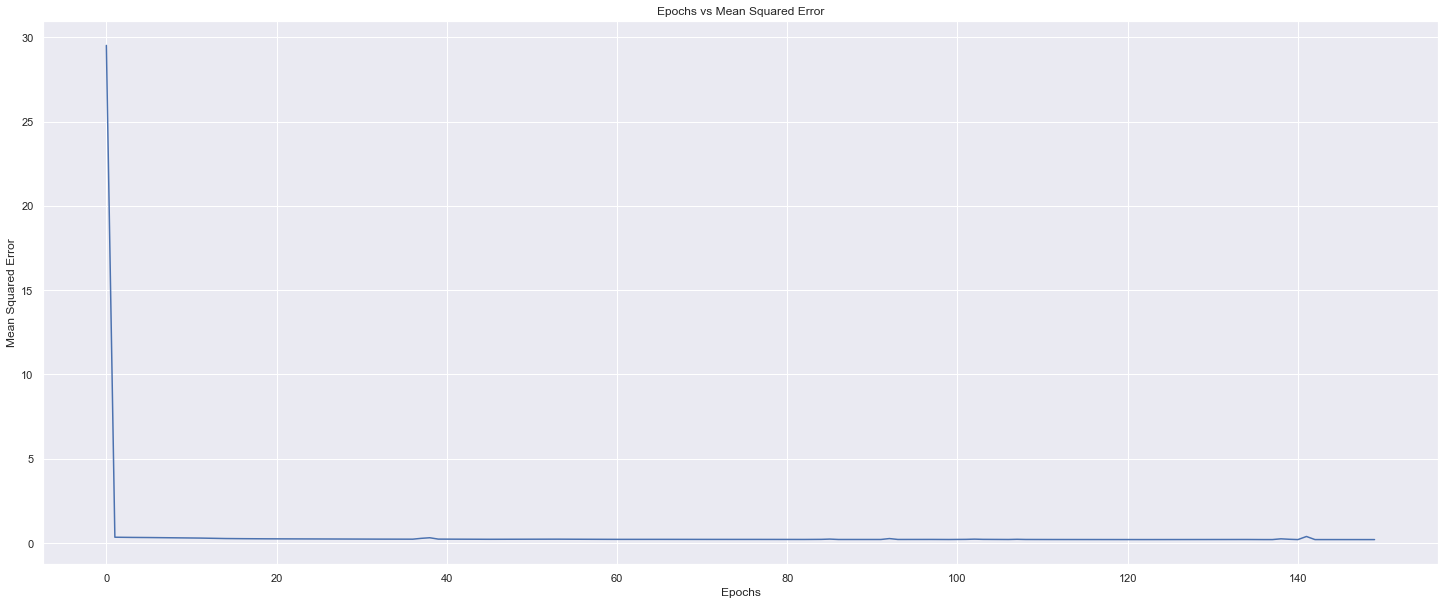

In [324]:
figure= sns.lineplot(data=history_df, x="Epochs", y="Mean Squared Error")
sns.set(rc={"figure.figsize":(25, 10)})
plt.title("Epochs vs Mean Squared Error" )

###### We can clearly see from the above graph that the mean squared error is not seeing a significant drop after 100 epochs. Given how expensive this is to compute, I computed 150 epochs and considered the mean squared error at that junction as the lowest MSE for this analysis.

In [325]:
# Creating a list of the various model types used
model_names = ['Linear Regression', 'Ridge Regression', 'LASSO', 'Deep Learning Keras - Linear Regression']
#Creating a list of polynomial degrees for various models
polynomial_degrees = [best_complexity_linreg, best_complexity_ridge, best_complexity_LASSO, 1]
# Creating a list of the Mean Squared errors of the various models.
MSE_List = [best_mse_linreg, best_mse_ridge, best_mse_LASSO, history.history['mse'][-1]]
list_of_results = list(zip(model_names, polynomial_degrees,MSE_List))
# Collating all of the above in a dataframe so that we can make a decision
Results_df = pd.DataFrame(list_of_results,
                  columns=['Model Name', 'Polynomial Degrees', 'Mean Squared Error'])
Results_df

,Model Name,Polynomial Degrees,Mean Squared Error
0,Linear Regression,2,0.147900
1,Ridge Regression,3,0.132321
2,LASSO,3,0.196705
3,Deep Learning Keras - Linear Regression,1,0.203415


###### From the above dataframe it is very evident that ridge regression with polynomial degree of 3 gives the lowest mean squared error and hence is the appropriate model to use. Also we know that the best alpha to use for ridge regression is 6.551, which is what will be used to build a model. This would allow me to maximize the accuracy in my model and hence give me the best prediction for my EUI

### Final model deployment

###### Implementing a ridge regression model with a polynomial degree of 3 for my features and a learning rate ( alpha) of 6.551

In [327]:
#Building a Ridge Regression model on the dataset with polynomial degree of 3. The parameters that are not numeric have been one hot encoded.

col_transformer_opt = make_column_transformer((PolynomialFeatures(degree = 3, include_bias=False),  ['Year_Factor','floor_area','year_built', 'energy_star_rating', 'ELEVATION', 
          'cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches','snowdepth_inches', 
          'avg_temp', 'days_below_30F', 'days_above_80F']),
                                        (OneHotEncoder(drop = 'if_binary', sparse=False, handle_unknown='ignore' ),['State_Factor', 'facility_type']),
                                             remainder='passthrough')

#Creating a ridge pipeline with a column transformer, scaler and the alpha that is the best alpha determined above
ridge_pipe_opt = Pipeline([
                      ("column_transformer", col_transformer_opt),
                      ('scaler', StandardScaler()),
                      ('ridge_opt', Ridge(alpha = best_alpha_ridge))])

#Fitting the ridge model and determining the predictions
model_opt= ridge_pipe_opt.fit(X_train, y_train)
ridge_train_preds_opt = model_opt.predict(X_train)
ridge_test_preds_opt = model_opt.predict(X_test)

# Calculating the mean squared errors.

ridge_train_mse_opt = mean_squared_error(y_train, ridge_train_preds_opt)
ridge_test_mse_opt = mean_squared_error(y_test, ridge_test_preds_opt)

In [328]:
#Determining the most important features in the dataset that impact the EUI. 
#This has been determined using the permutation importance determination

r = permutation_importance(model_opt, X_test, y_test,
                           n_repeats=10,
                           random_state=22, scoring = 'r2')

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0.005:
        print(f"{features[i]:<20}"
              f"{r.importances_mean[i]:.2f}"
              f" +/- {r.importances_std[i]:.2f}")

energy_star_rating  0.68 +/- 0.01
facility_type       0.37 +/- 0.01
heating_degree_days 0.21 +/- 0.00
days_below_30F      0.11 +/- 0.00
days_above_80F      0.06 +/- 0.00
snowfall_inches     0.06 +/- 0.00
avg_temp            0.06 +/- 0.00
Year_Factor         0.05 +/- 0.00
snowdepth_inches    0.05 +/- 0.00
State_Factor        0.04 +/- 0.00
cooling_degree_days 0.04 +/- 0.00
precipitation_inches0.03 +/- 0.00
ELEVATION           0.02 +/- 0.00
floor_area          0.01 +/- 0.00


###### From the above analysis we can clearly see that the 5 most important aspects affecting EUI are: Energy star rating, facility type, heating degree days, days below 30F and days above 80F

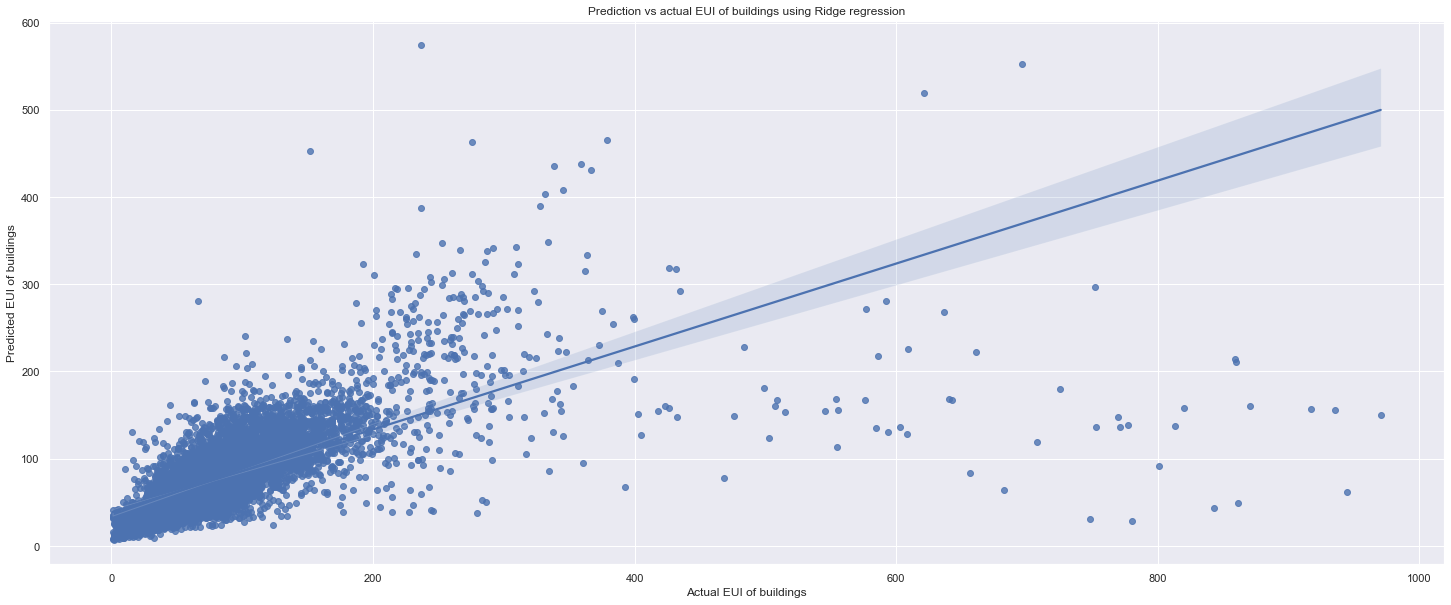

In [329]:
# Creating a plot of the predicted EUI and the actual EUI to see the correlation. 
sns.regplot(x= np.exp(y_test),y= np.exp(ridge_test_preds_opt), marker='o')
sns.set(rc={"figure.figsize":(10,10)})
plt.xlabel("Actual EUI of buildings")
plt.ylabel("Predicted EUI of buildings")
plt.title("Prediction vs actual EUI of buildings using Ridge regression" )
plt.show()

###### Given the correlation between Actual EUI of buildings and Predicted EUI of buildings is fairly linear we can safely assume that the model is a good fit and the model is doing a reasonable job of predicting EUI

In [330]:
#Creating a dataframe of actual EUI from our existing data
Actual_EUI_df= pd.DataFrame(np.exp(y_test))

#Creating a dataframe of the predicted EUI from our ridge model and renaming the column to predicted EUI
Prediction_EUI_df= pd.DataFrame(np.exp(ridge_test_preds_opt))
Prediction_EUI_df.rename(columns = { 0:'Predicted_EUI'}, inplace = True)

#Assigning our test dataframe value to a new dataframe
Prediction_df = X_test

#Attaching the prices of the existing data with the existing parameters

Prediction_df['Actual_EUI'] = Actual_EUI_df['site_eui']

#Reseting the index to ensure that the predicted prices can be attached a complete dataframe can be made to make inferences.
Prediction_df = Prediction_df.reset_index()
Prediction_df['Predicted_EUI'] = Prediction_EUI_df['Predicted_EUI']
Prediction_df.drop(['index'], axis=1, inplace=True)
Prediction_df.head()

,Year_Factor,State_Factor,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_above_80F,Actual_EUI,Predicted_EUI
0,4,State_6,Office_Uncategorized,247919.0,1964.0,60.0,42.7,1128,4875,53.79,50.0,377,54.501370,66,75,113.433132,95.684640
1,6,State_6,Multifamily_Uncategorized,97000.0,1928.0,19.0,25.0,1489,4252,42.17,36.0,101,57.215847,40,96,107.704918,105.798761
2,5,State_4,Education_Other_classroom,106366.0,1930.0,88.0,165.5,769,6226,41.75,44.8,426,49.800000,96,64,37.154214,50.991450
3,6,State_8,Office_Uncategorized,1335092.0,1987.0,76.0,3.0,1114,5074,35.78,13.9,18,53.839335,97,101,58.928174,84.402078
4,5,State_6,Multifamily_Uncategorized,72300.0,1983.0,56.0,42.7,1581,4460,40.97,49.1,463,56.835616,63,106,91.654778,83.380229


In [331]:
# Creating a bar plot using plotly to determine the EUI based on the facility type
Prediction_df_group_star = Prediction_df.groupby(['energy_star_rating']).mean()
Prediction_df_group_star.reset_index(inplace=True)
px.bar(Prediction_df_group_star, x='energy_star_rating', y='Predicted_EUI',title ='Bar plot of average predicted EUI based on Energy Star rating')

###### From the above graph we can clearly see that as the energy star rating of a building increases the average EUI decreses and hence there is an inverse relationship between energy star rating and EUI

In [337]:
# Creating a bar plot using plotly to determine the EUI based on the facility type
Prediction_df_group_facility = Prediction_df.groupby(['facility_type']).mean()
Prediction_df_group_facility.reset_index(inplace=True)
px.bar(Prediction_df_group_facility, x='facility_type', y='Predicted_EUI', title ='Bar plot of average predicted EUI based on facility type')

###### From the above graph we can clearly see that Health care inpatient facilties have the highest  average Energy Use Intensity of all building types, with an  average EUI of 240 units of heat and electricity consumed. This is closely followed by Grocery store, with an average EUI of 232 units, and data center with an average EUI of 183 units.

In [338]:
# Creating a bar plot using plotly to determine the EUI based on the facility type
Prediction_df_tot_days = Prediction_df
Prediction_df_tot_days['Total degree days'] = Prediction_df['heating_degree_days'] + Prediction_df['cooling_degree_days']
Prediction_df_total_days = Prediction_df_tot_days.groupby(['Total degree days']).mean()
Prediction_df_total_days.reset_index(inplace=True)
px.line(Prediction_df_total_days, x='Total degree days', y='Predicted_EUI', title ='Line plot of average predicted EUI based on degree days')

###### From the above graph we see that the average EUI of buildings increases as the total number of degree days increases. The peak mean EUI is at 6863 degree days from where there is a decline. The heating degree days are overwhelmingly more than cooling degree days. This is what is driving the total EUI and hence we see the total EUI peaking as the total number of heating degree days peak

In [339]:
px.violin(Prediction_df, x='State_Factor', y='Predicted_EUI', title ='Box plot of predicted EUI based on state factor')

###### From the above chart we can clealy see that State 6 has the highest median EUI of 84 units and the largest spread of EUI among its building stock, followed by state 10

In [342]:
# Creating a bar plot using plotly to determine the EUI based on the facility type
Prediction_df_group = Prediction_df.groupby(['year_built']).mean()
Prediction_df_group.reset_index(inplace=True)
Prediction_df_group_year = Prediction_df_group.loc[Prediction_df_group['year_built'] > 1900]
px.line(Prediction_df_group_year, x='year_built', y='Predicted_EUI',
       title ='Line plot of predicted EUI based on year built')

###### From the above chart we can clearly see that building EUI has seen a rapid decline post the year 2000 and prior to the building energy use intensity remained "flat" with some localised peaks and troughs. The EUI drop from 1999 to 2014 is ~ 50 units of electricity and gas consumed

# Results and recommendations

##### Results

The results of the data analysis is as follows: 

a)The factors that affected the EUI the most are as follows:
             
             a.Energy star rating
             b.Facility type
             c.Heating degree days 
             d.Days below 30F
             e.Days above 80 F
             f.Snowfall in inches
             g.Average temperature

b)There is an inverse relationship between energy star rating and energy use intensity, with energy use intensity decreasing as the star rating increases. The highest energy star rating (100) used 20% (34 units of gas and electricity) compared to the lowest energy star rating building (1) that used (157 units of gas and electricity)

c)In-patient health care facilities were the most energy intensive buildings with an EUI of 240 units of gas and electricity. This is closely followed by Grocery store, with an average EUI of 232 units, and data center with an average EUI of 183 units.

d)Heating degree days resulted in an overwhelming amount of Energy use intensity increase as compared to cooling degree days. The total degree days that resulted in the most energy use intensity perfectly coincided with the peak of heating degree days. The peak mean EUI is at 6863- total heating and cooling degree days from where there is a decline.  

e)State 6 has the highest median EUI of 84 units and the largest spread of EUI among its building stock, followed by state 10

f)EUI has seen a rapid decline post the year 2000 and prior to the building energy use intensity remained "flat" with some localized peaks and troughs. The EUI drop from 1999 to 2014 is ~ 50 units of electricity and gas consumed ( 50% reduction).

##### Recommendations

Recommendations for each stakeholder are as follows:

a) Designers: 
            
            1) Design buildings and retrofit them to get the highest energy star rating. The increased cost will pay itself back with 80% reduction in energy use.
            2) In-patient health care facilities need to have the most energy efficiency measures in design like LED lights, high coefficient of performance equipment, excellent insulation, double pane windows etc           
            3) Design buildings to maximize heat gain as heating is the dominant use of energy, with 50F being the temperature where all heat loss should be calculated as it is the temperature at which EUI is maximum.
          
b) Building operators:
            
            1) In-patient health care facilities should get energy efficiency retrofits ( lower energy usage equipment, lights, better insulation etc)            
            2) Retrofit older buildings ( built before 2000) with newer equipment since equipment post 2000 seems to consume less energy as overall energy use post 2000 has decreased
            3) When predicted temperature is between 55-60F, building operators should try to use on-site renewable sources of energy to lower energy demand from the grid
            
c) Lawmakers/policy makes: 
            
            1) Incentivize lower energy use among buildings and target regions with high median EUI, like state 6 and state 10.
            2) Provide cheap financing to make retrofits to more energy efficient equipment in regions with high median EUI. 

# Next Steps

The next steps can be as follows:

a) Improve the presented models: 
         
         1) Increased epochs in deep learning models, 
         2) Higher polynomials of data to improve outcomes. 
         3) Using ensemble techniques to see if combination of models can give more accurate results.
     
Each of the above mentioned steps can be attempted but may be very computationally expensive so the cost must be weighed against the expenses.  
     
b) Measure the results of the test data with actual field data to validate this model and refine it further.